Trebaju nam sljedeće biblioteke.

In [3]:
import scipy.io
import numpy as np
import tensorly as tl

In [ ]:
!pip install tensorly

Unosimo datasetove.

Za prvo testiranje koda, samo dataset s Merlina *(subset of the US Postal Service Database, downloaded them from the web page of the book The Elements of Statistical Learning, Hastie, Tibshirani and Friedman (2001). Springer-Verlag)*.

Kasnije uzimamo pravi skup MNIST s 70 000 unosa.

In [ ]:
X_train = scipy.io.loadmat('azip.mat')['azip'].T
y_train = scipy.io.loadmat('dzip.mat')['dzip'][0]
X_test = scipy.io.loadmat('testzip.mat')['testzip'].T
y_test = scipy.io.loadmat('dtest.mat')['dtest'][0]

In [5]:
mnist = scipy.io.loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [7]:
mnist_data = mnist_data.astype(np.float32) / 255.0

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_label, test_size=0.2, random_state=42, stratify=mnist_label)

In [ ]:
len(X_train)        # kolicina podataka za treniranje

56000

In [ ]:
len(X_train[1])     # dimenzija znamenke - 28 * 28 (serijalizirano)

784

Pospremimo dio podataka za trening modela - znamenke u svoje tenzore po klasama, tako da matrice uzoraka jedne klase spremimo kao frontalne sliceove tenzora te klase.

In [9]:
digit_indices = {i: np.where(y_train == i)[0] for i in range(10)}

A_tensors = {
    i: tl.tensor(X_train[digit_indices[i]].reshape(-1, 28, 28).transpose(1, 2, 0))
    for i in range(10)
}

for i in range(10): print(f"A_{i}.shape: {A_tensors[i].shape}")

A_0.shape: (28, 28, 5522)
A_1.shape: (28, 28, 6302)
A_2.shape: (28, 28, 5592)
A_3.shape: (28, 28, 5713)
A_4.shape: (28, 28, 5459)
A_5.shape: (28, 28, 5050)
A_6.shape: (28, 28, 5501)
A_7.shape: (28, 28, 5834)
A_8.shape: (28, 28, 5460)
A_9.shape: (28, 28, 5567)


### HOSVD

In [13]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tenalg import mode_dot
import time

In [100]:
outer_sums = {}

for i in range(10):

    core, factors = tucker(A_tensors[i], rank=[25, 25, 30])
    S, [U, V, W] = core, factors
    R3 = S.shape[2]

    outer_sum = [mode_dot(mode_dot(S[:, :, j], U, mode=0), V, mode=1) for j in range(R3)]
    outer_sum = [A_j / np.linalg.norm(A_j, 'fro') for A_j in outer_sum]

    outer_sums[i] = outer_sum


Za ovo je trebalo puno vremena, 43 sekunde, no to je preprocessing pa je u redu.

**Testiranje testnog skupa s uzimanjem cijelih potprostora (bez rezanja).**

In [ ]:
correct = 0

_range = len(X_test)
start_time = time.time()
for i in range(_range):
    x = X_test[i].reshape(28, 28)
    x = x / np.linalg.norm(x, 'fro')

    projection_sums = {}

    for j in range(10):
        projections = [tl.tenalg.inner(x, A_j) for A_j in outer_sums[j]]
        projection_sums[j] = 1 - np.sum(np.square(projections))
        # print(f"Class {j}: {projection_sums[j]}")

    min_class, min_value = min(projection_sums.items(), key=lambda x: x[1])
    # print(y_test[i], min_class, min_value)
    if min_class == y_test[i]: correct += 1
    # else:
    #     print("guessed:", min_class, "correct:", y_test[i])
    #     for j in range(10): print(f"Class {j}: {projection_sums[j]}")
    
end_time = time.time()
elapsed_time = end_time - start_time
time_per_digit = elapsed_time / _range

print(f"{(correct / _range) * 100:.1f}% | Time: {elapsed_time:.2f} sec | Time per digit: {time_per_digit:.4f} sec")

95.3%


#### Usporedba: ovisnost vremena i točnosti o `basis_size` - veličina baze

Rezultat za `rank=[25,25,30]`.

In [ ]:
for basis_size in range(1, 31):
    start_time = time.time()
    
    correct = 0

    _range = len(X_test)

    for i in range(_range):
        x = X_test[i].reshape(28, 28)
        x = x / np.linalg.norm(x, 'fro')

        projection_sums = {}

        for j in range(10):
            projections = [tl.tenalg.inner(x, A_j) for A_j in outer_sums[j][:basis_size]]
            projection_sums[j] = 1 - np.sum(np.square(projections))
            # print(f"Class {j}: {projection_sums[j]}")

        min_class, min_value = min(projection_sums.items(), key=lambda x: x[1])
        # print(y_test[i], min_class, min_value)
        if min_class == y_test[i]: correct += 1
        # else:
        #     print("guessed:", min_class, "correct:", y_test[i])
        #     for j in range(10): print(f"Class {j}: {projection_sums[j]}")
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_per_digit = elapsed_time / _range

    print(f"{basis_size}: {(correct / _range) * 100:.1f}% | Time: {elapsed_time:.2f} sec | Time per digit: {time_per_digit:.4f} sec")

1: 81.3% | Time: 2.32 sec | Time per digit: 0.0002 sec
2: 86.8% | Time: 3.40 sec | Time per digit: 0.0002 sec
3: 89.9% | Time: 4.35 sec | Time per digit: 0.0003 sec
4: 91.1% | Time: 5.20 sec | Time per digit: 0.0004 sec
5: 92.2% | Time: 6.16 sec | Time per digit: 0.0004 sec
6: 92.5% | Time: 7.11 sec | Time per digit: 0.0005 sec
7: 93.3% | Time: 8.03 sec | Time per digit: 0.0006 sec
8: 93.6% | Time: 9.13 sec | Time per digit: 0.0007 sec
9: 93.9% | Time: 9.88 sec | Time per digit: 0.0007 sec
10: 94.1% | Time: 10.62 sec | Time per digit: 0.0008 sec
11: 94.5% | Time: 11.55 sec | Time per digit: 0.0008 sec
12: 94.7% | Time: 12.42 sec | Time per digit: 0.0009 sec
13: 94.8% | Time: 13.35 sec | Time per digit: 0.0010 sec
14: 94.7% | Time: 14.25 sec | Time per digit: 0.0010 sec
15: 94.8% | Time: 15.15 sec | Time per digit: 0.0011 sec
16: 95.0% | Time: 16.03 sec | Time per digit: 0.0011 sec
17: 95.2% | Time: 16.99 sec | Time per digit: 0.0012 sec
18: 95.2% | Time: 17.91 sec | Time per digit: 0.0

Probajmo malo sažeti početnu aproksimaciju HOSVD-a da malo skupimo podatke i ne trebamo tako veliki k za *peak* preciznosti. Uzmimo `rank=[20,20,20]`.

In [ ]:
outer_sums = {}

for i in range(10):

    # HOSVD
    core, factors = tucker(A_tensors[i], rank=[20, 20, 20])
    S, [U, V, W] = core, factors
    R3 = S.shape[2]

    outer_sum = [mode_dot(mode_dot(S[:, :, j], U, mode=0), V, mode=1) for j in range(R3)]
    outer_sum = [A_j / np.linalg.norm(A_j, 'fro') for A_j in outer_sum]

    outer_sums[i] = outer_sum


Za manje, `rank=[15,15,15]`, dobivamo skoro iste rezultate a čak i malo lošije vrijeme tako da se ne isplati smanjivati toliko.

In [ ]:
outer_sums = {}

for i in range(10):

    # HOSVD
    core, factors = tucker(A_tensors[i], rank=[15, 15, 15])
    S, [U, V, W] = core, factors
    R3 = S.shape[2]

    outer_sum = [mode_dot(mode_dot(S[:, :, j], U, mode=0), V, mode=1) for j in range(R3)]
    outer_sum = [A_j / np.linalg.norm(A_j, 'fro') for A_j in outer_sum]

    outer_sums[i] = outer_sum


In [ ]:
for basis_size in range(1, 16):
    start_time = time.time()

    correct = 0

    _range = len(X_test)

    for i in range(_range):
        x = X_test[i].reshape(28, 28)
        x = x / np.linalg.norm(x, 'fro')

        projection_sums = {}

        for j in range(10):
            projections = [tl.tenalg.inner(x, A_j) for A_j in outer_sums[j][:basis_size]]
            projection_sums[j] = 1 - np.sum(np.square(projections))
            # print(f"Class {j}: {projection_sums[j]}")

        min_class, min_value = min(projection_sums.items(), key=lambda x: x[1])
        # print(y_test[i], min_class, min_value)
        if min_class == y_test[i]: correct += 1
        # else:
        #     print("guessed:", min_class, "correct:", y_test[i])
        #     for j in range(10): print(f"Class {j}: {projection_sums[j]}")
        
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_per_digit = elapsed_time / _range

    print(f"{basis_size}: {(correct / _range) * 100:.1f}% | Time: {elapsed_time:.2f} sec | Time per digit: {time_per_digit:.4f} sec")

1: 81.3% | Time: 2.30 sec | Time per digit: 0.0002 sec
2: 86.8% | Time: 3.35 sec | Time per digit: 0.0002 sec
3: 89.9% | Time: 4.31 sec | Time per digit: 0.0003 sec
4: 91.1% | Time: 5.09 sec | Time per digit: 0.0004 sec
5: 92.2% | Time: 6.10 sec | Time per digit: 0.0004 sec
6: 92.5% | Time: 7.18 sec | Time per digit: 0.0005 sec
7: 93.4% | Time: 8.06 sec | Time per digit: 0.0006 sec
8: 93.6% | Time: 9.13 sec | Time per digit: 0.0007 sec
9: 93.9% | Time: 10.02 sec | Time per digit: 0.0007 sec
10: 94.1% | Time: 11.26 sec | Time per digit: 0.0008 sec
11: 94.5% | Time: 12.10 sec | Time per digit: 0.0009 sec
12: 94.7% | Time: 12.77 sec | Time per digit: 0.0009 sec
13: 94.8% | Time: 13.80 sec | Time per digit: 0.0010 sec
14: 94.7% | Time: 14.60 sec | Time per digit: 0.0010 sec
15: 94.8% | Time: 15.77 sec | Time per digit: 0.0011 sec


## HOSVD s kompresijom

#### Trening faza

Prvo sortiramo i vektoriziramo znamenke formirajući tenzor D gdje svaki frontalni slice odgovara jednoj klasi - vektori duljine 784 kao redovi slicea. Moramo odabrati fiksni broj uzoraka po klasi.

In [ ]:
N_samples_per_class = 5000

D_list = []
for i in range(10):
    idx = digit_indices[i][:N_samples_per_class]
    # X_train ima oblik (n_uzoraka, 28, 28)
    # Preuređujemo tako da dobijemo matricu oblika (28*28, N_samples_per_class):
    class_data = X_train[idx]         
    class_data = class_data.reshape(N_samples_per_class, -1).T  #  (784, N_samples_per_class)
    D_list.append(class_data)
D = np.stack(D_list, axis=2) # (784, N_samples_per_class, 10)


Parametri redukcije:  
p – nova dimenzija u pixel modeu  
q – broj uzoraka po klasi nakon redukcije


In [11]:
p = 100   
q = 50     

HOSVD na tenzoru D

In [18]:
core, factors = tucker(D, rank=[p, q, 10])
U_p, V_q, W = factors  # U_p: (784, p), V_q: (N_samples_per_class, q), W: (10, 10)

Definiramo reducirani tenzor F koji predstavlja trening skup.

In [19]:
F = tl.tenalg.mode_dot(D, U_p.T, mode=0)
F = tl.tenalg.mode_dot(F, V_q.T, mode=1)

In [23]:
F.shape

(100, 50, 10)

Za svaku klasu računamo bazne matrice B radeći SVD nad F.

In [22]:
k = 10  # broj baznih matrica
B_matrices = {}
for i in range(10):
    F_i = F[:, :, i]  # F_i: podmatrica za klasu i, oblik (p, q)
    U_i, s, Vh_i = np.linalg.svd(F_i, full_matrices=False)
    B_i = U_i[:, :k]  # B_i: (p, k)
    # normaliziramo stupce
    for j in range(B_i.shape[1]):
        B_i[:, j] /= np.linalg.norm(B_i[:, j])
    B_matrices[i] = B_i

### Testiranje

Prvo odredimo reprezentaciju nepoznate znamenke, potom izračunamo reziduale i odredimo indeks minimalnog reziduala.

In [ ]:
correct_alg2 = 0
num_test = len(X_test)
start_time_alg2 = time.time()
for i in range(num_test):
    d = X_test[i].reshape(-1)   # d: (28*28 = 784,)
    norm_d = np.linalg.norm(d)
    if norm_d == 0:
        continue
    d = d / norm_d
    # Projekcija d na reducirani prostor pomoću U_p
    d_p = U_p.T @ d          # d_p: (p,)
    
    residuals = {}
    for c in range(10):
        B_c = B_matrices[c]  # B_c: (p, k)
        # LS rješenje: x_hat = B_c.T @ d_p (budući da su stupci ortonormirani)
        x_hat = B_c.T @ d_p
        d_recon = B_c @ x_hat
        residual = np.linalg.norm(d_p - d_recon)**2
        residuals[c] = residual
    pred_class = min(residuals, key=residuals.get)
    if pred_class == y_test[i]:
        correct_alg2 += 1
end_time_alg2 = time.time()
elapsed_alg2 = end_time_alg2 - start_time_alg2
time_per_digit_alg2 = elapsed_alg2 / num_test

print(f"\n HOSVD s kompresijom: {(correct_alg2 / num_test) * 100:.1f}% | Time: {elapsed_alg2:.2f} sec | Time per digit: {time_per_digit_alg2:.4f} sec")


 Algorithm 2 (Compression and classification by HOSVD): 93.7% | Time: 3.30 sec | Time per digit: 0.0002 sec


### Varijacija parametara p i q:

p=50, q=30 --> Accuracy: 93.0%
p=50, q=40 --> Accuracy: 93.3%
p=50, q=50 --> Accuracy: 93.6%
p=50, q=60 --> Accuracy: 93.8%
p=75, q=30 --> Accuracy: 93.1%
p=75, q=40 --> Accuracy: 93.5%
p=75, q=50 --> Accuracy: 93.7%
p=75, q=60 --> Accuracy: 93.8%
p=100, q=30 --> Accuracy: 93.3%
p=100, q=40 --> Accuracy: 93.7%
p=100, q=50 --> Accuracy: 93.7%
p=100, q=60 --> Accuracy: 94.0%
p=125, q=30 --> Accuracy: 93.3%
p=125, q=40 --> Accuracy: 93.6%
p=125, q=50 --> Accuracy: 93.8%
p=125, q=60 --> Accuracy: 94.0%
p=150, q=30 --> Accuracy: 93.4%
p=150, q=40 --> Accuracy: 93.7%
p=150, q=50 --> Accuracy: 93.8%
p=150, q=60 --> Accuracy: 94.0%


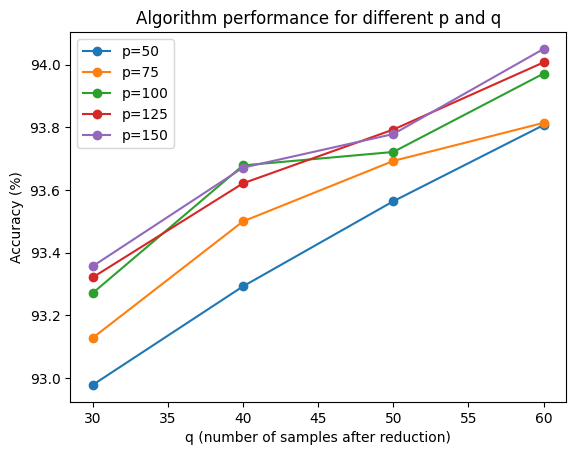

In [25]:
import matplotlib.pyplot as plt

# Definiramo raspon vrijednosti za p i q
p_values = [50, 75, 100, 125, 150]
q_values = [30, 40, 50, 60]

results = {}

for p_val in p_values:
    for q_val in q_values:
        # Tucker dekompozicija
        core, factors = tucker(D, rank=[p_val, q_val, 10])
        U_p, V_q, W = factors
        F = tl.tenalg.mode_dot(core, W, mode=2)
        
        # Za svaki razred dobivamo bazne matrice B 
        k = 10
        B_matrices = {}
        for i in range(10):
            F_i = F[:, :, i]
            U_i, s, Vh_i = np.linalg.svd(F_i, full_matrices=False)
            B_i = U_i[:, :k]
            for j in range(B_i.shape[1]):
                B_i[:, j] /= np.linalg.norm(B_i[:, j])
            B_matrices[i] = B_i

        # Faza testiranja
        correct_alg2 = 0
        for i in range(num_test):
            d = X_test[i].reshape(-1)
            norm_d = np.linalg.norm(d)
            if norm_d == 0:
                continue
            d = d / norm_d
            d_p = U_p.T @ d
            residuals = {}
            for c in range(10):
                B_c = B_matrices[c]
                x_hat = B_c.T @ d_p
                d_recon = B_c @ x_hat
                residuals[c] = np.linalg.norm(d_p - d_recon)**2
            pred_class = min(residuals, key=residuals.get)
            if pred_class == y_test[i]:
                correct_alg2 += 1
        accuracy = correct_alg2 / num_test * 100
        results[(p_val, q_val)] = accuracy
        print(f"p={p_val}, q={q_val} --> Accuracy: {accuracy:.1f}%")

# Prikaz  rezultata
fig, ax = plt.subplots()
for p_val in p_values:
    accs = [results[(p_val, q_val)] for q_val in q_values]
    ax.plot(q_values, accs, marker='o', label=f"p={p_val}")
ax.set_xlabel("q (number of samples after reduction)")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Algorithm performance for different p and q")
ax.legend()
plt.show()

Bez obzira na različite kombinacije parametara p i q, algoritam postiže sličnu točnost 93–94%.
Usporedno s prvim algoritmom (koji je davao oko 94–96% točnosti ovisno o veličini baze potprostora, ali sporije radi), ovdje je točnost malo manja, ali je izvođenje puno brže (3.30 sekundi naspram 10+ sekundi).

### Matrica konfuzije i izvještaj o klasifikaciji:

Pogledajmo koliko se dobro test uzorak može „predstaviti“ pomoću baze svake klase u reduciranom prostoru.

In [ ]:
!pip install seaborn

Confusion Matrix:
[[1354    4    3    1    1    3   11    0    4    0]
 [   0 1554   10    1    1    0    0    3    6    0]
 [  18   10 1301   11    6    3   11   11   23    4]
 [   6    7   13 1318    0   27    2   13   36    6]
 [   3   19    4    0 1294    0   11    2    5   27]
 [  10    4    0   40    0 1167   17    1   14   10]
 [  14   11    0    0    1   12 1334    0    3    0]
 [   4   17   13    0   11    0    0 1343    5   66]
 [  13   21    8   20    3   42    5    6 1231   16]
 [  10   17    2   15   32    3    1   28   12 1271]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1381
         1.0       0.93      0.99      0.96      1575
         2.0       0.96      0.93      0.95      1398
         3.0       0.94      0.92      0.93      1428
         4.0       0.96      0.95      0.95      1365
         5.0       0.93      0.92      0.93      1263
         6.0       0.96      0.97      0.96     

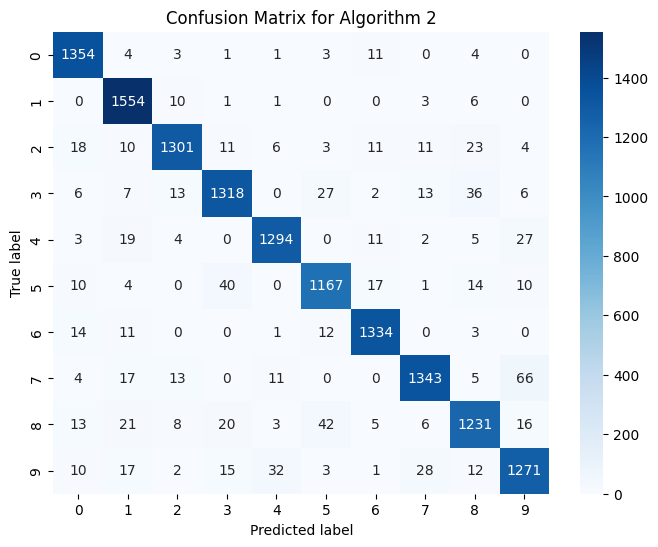

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Izračun predviđanja 
predictions = []
residuals_all = []  # spremamo i preostale reziduale za dodatnu analizu

for i in range(num_test):
    d = X_test[i].reshape(-1)   # d: (784,)
    norm_d = np.linalg.norm(d)
    if norm_d == 0:
        predictions.append(-1)
        continue
    d = d / norm_d
    # Projekcija na reducirani prostor pomoću U_p
    d_p = U_p.T @ d          # d_p: (p,)
    
    res = {}
    for c in range(10):
        B_c = B_matrices[c]  # B_c: (p, k)
        # LS rješenje
        x_hat = B_c.T @ d_p
        d_recon = B_c @ x_hat
        res[c] = np.linalg.norm(d_p - d_recon)**2
    pred_class = min(res, key=res.get)
    predictions.append(pred_class)
    residuals_all.append(res[pred_class])
    
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Prikaz matrice konfuzije 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix for Algorithm 2")
plt.show()

Matrica konfuzije pokazuje da su neke znamenke (npr. 1, 0, 2, 6, 7) pretežno dobro klasificirane (visoka dijagonalna vrijednost).
Klase 5, 8 i 9 nešto su češće krivo klasificirane (vidljivo iz niže preciznosti/reziduala).
Iz izvještaja o klasifikaciji vidimo da su preciznost i rezidual (f1-score) generalno dobri (oko 0.90+), ali se za neke znamenke (npr. 5, 8, 9) vidi lagani pad.

#### Analiza distribucije preostalih reziduala:


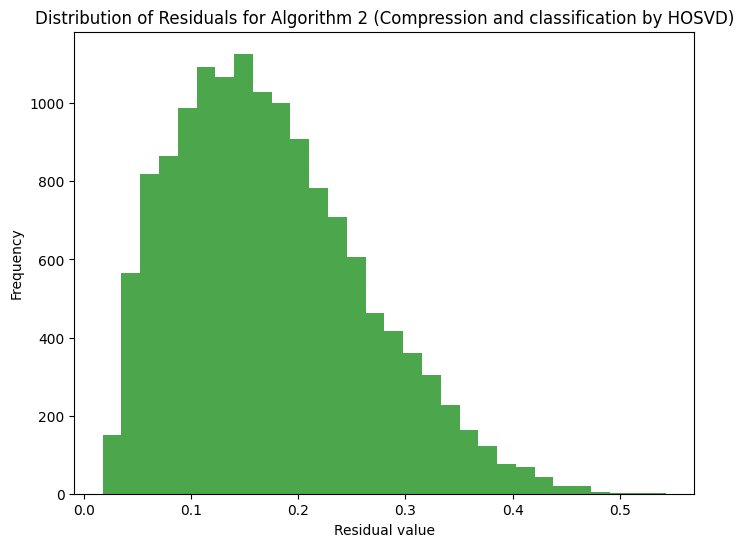

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(residuals_all, bins=30, color='green', alpha=0.7)
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals for Algorithm 2 (Compression and classification by HOSVD)")
plt.show()

Većina reziduala nalazi se u rasponu od otprilike 0.1 do 0.3, što znači da se većina znamenki može relativno dobro rekonstruirati u zajedničkom reduciranom prostoru. Manji broj uzoraka ima veće reziduale (do 0.5), što implicira da su to “teži” slučajevi za koje baza klase ne nudi dobru aproksimaciju.